# Notebook for the analysis of segmentation networks, generating graphs and figures

In [1]:
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import time
import datetime
import os
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from importlib import reload
import model_fcts as mod
import preprocessing_fcts as pp
import loss_fcts as loss

from seg_models import PixUnet, CustomUnet512, Custom_naderi_net, ASPP_net, ASPP_net512

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load datasets

In [2]:
def make_seg_ds(res, set_type, threshold = 0.01):
    """
    Make the dataset used as input for the segmentation network
    Function copied from the notebook 'train_seg'
    """
    ds_path = 'tf_dataset/' + set_type + '_dataset_' + str(res)
    ds = tf.data.Dataset.load(ds_path)
    ds = ds.map(lambda x, y: (x, x[:,:,0] - y))
    ds = ds.map(lambda x,y: (x, tf.cast(tf.math.greater(y, tf.constant(threshold)), dtype='float32')))
    ds = ds.map(lambda x, y : (x, y, (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0]))))
    ds = ds.map(lambda x, y, z:(tf.concat([tf.expand_dims(pp.normalize(x[:,:,0], z[0], z[1]), axis=-1),pp.normalize_rgb(x[:,:,1:])], axis=-1), tf.expand_dims(y, axis=-1)))
    
    return ds

In [3]:
test_dataset = make_seg_ds(256, 'test').batch(1)
raw_dataset = tf.data.Dataset.load('tf_dataset/test_dataset_256')
images = raw_dataset.map(lambda x, y :x[:,:,1:])

In [4]:
test_dataset512 = make_seg_ds(512, 'test').batch(1)
raw_dataset512 = tf.data.Dataset.load('tf_dataset/test_dataset_512')
images512 = raw_dataset512.map(lambda x, y :x[:,:,1:])

## nDSM and ground truth visualisations

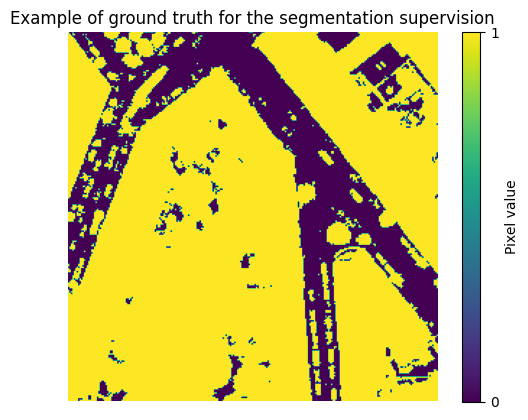

In [5]:
for i in test_dataset.map(lambda x,y: y).take(1):
    plt.imshow(i[0][:,:,0])
    plt.title('Example of ground truth for the segmentation supervision')
    cbar = plt.colorbar()
    cbar.set_ticks([0.0,1.0])
    cbar.set_ticklabels(['0', '1'])
    cbar.ax.set_ylabel('Pixel value')
    plt.axis('off')
    plt.savefig('Figures/point labelling/gt_example.png')

In [6]:
ndsm = raw_dataset.map(lambda x,y: x[:,:,0] - y)

photos = [i for i in images.take(20)]

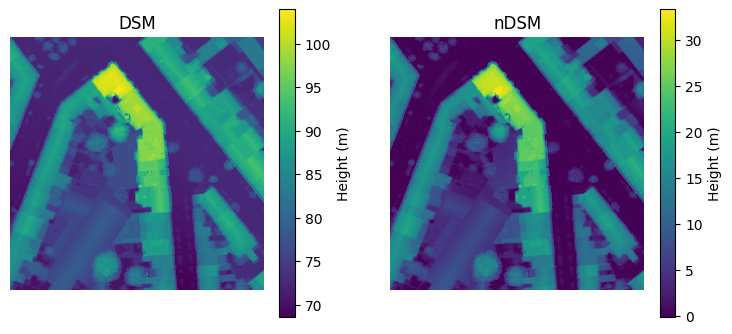

In [7]:
ex_ndsm = [i for i in ndsm.take(1)][0]
ex_dsm = [i for i in raw_dataset.map(lambda x, y: x[:,:,0]).take(1)][0]

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(9)
ax = axs[0]
ax.title.set_text('DSM')
ax.axis('off')
im = ax.imshow(ex_dsm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Height (m)')


ax = axs[1]
ax.title.set_text('nDSM')
im = ax.imshow(ex_ndsm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Height (m)')
ax.axis('off')
plt.savefig('Figures/point labelling/ndsm_example.png')

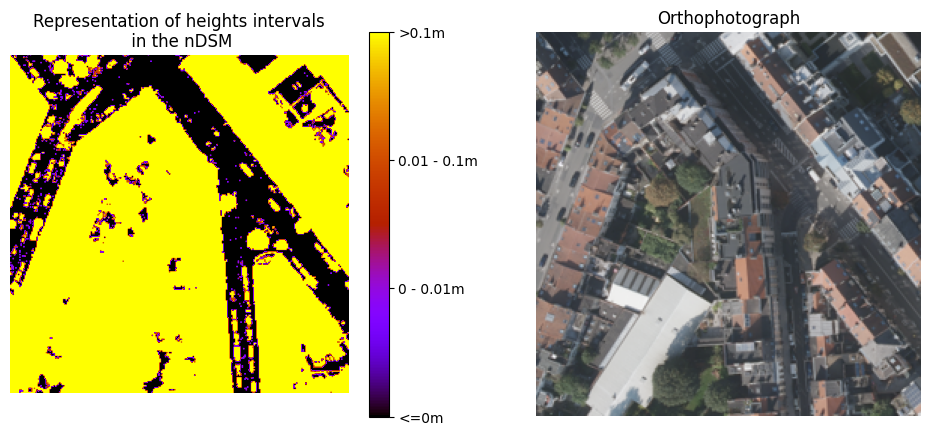

In [8]:
def make_gt_threshold_image(ndsm):
    gt = tf.cast(tf.math.greater(ndsm, tf.constant(0.0)), dtype='int32')
    gt += tf.cast(tf.math.greater(ndsm, tf.constant(0.01)), dtype='int32')
    gt += tf.cast(tf.math.greater(ndsm, tf.constant(0.1)), dtype='int32')
    return tf.cast(gt, dtype='int32')

gt = ndsm.map(lambda x: make_gt_threshold_image(x))
n=0

for i in gt.take(20):  
    if n == 0:
        fig, axs = plt.subplots(1,2)
        fig.set_figheight(6)
        fig.set_figwidth(12)
        ax = axs[0]
        ax.title.set_text('Representation of heights intervals\n in the nDSM')
        ax.axis('off')
        im = ax.imshow(i, cmap='gnuplot')
        fig.set_figheight(5)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0.0,1.0,2.0,3.0])
        cbar.set_ticklabels(['<=0m', '0 - 0.01m', '0.01 - 0.1m', '>0.1m'])

        ax = axs[1]
        ax.title.set_text('Orthophotograph')
        im = ax.imshow(tf.cast(photos[n], dtype='int32'))
        ax.axis('off')
        #plt.savefig('Figures/point labelling/intervals.png')
    n += 1  

## Tensorboard graphs

In [ ]:
%tensorboard --logdir /home/student/data/logs/SEG --host 0.0.0.0

## Load models

In [9]:
model_names = os.listdir('training_checkpoints/seg')
for i, name in enumerate(model_names):
    print(i, name)

0 pix_512
1 pix_suite
2 seg_model
3 pix_sig_30
4 pix_10cm
5 pix20ep


In [13]:
models = [{'name':'seg_model', 'net_type':'PixUnet', 'res':512, 'activ':'sigmoid', 'relu':True}
         ]

In [11]:
models

[{'name': 'seg_model',
  'net_type': 'PixUnet',
  'res': 256,
  'activ': 'sigmoid',
  'relu': True}]

In [12]:
def load_model(name, net_type, res, activ, relu):
    net_fct = globals()[net_type]
    inputs = tf.keras.layers.Input(shape=[res, res, 4])
    net = net_fct(inputs, relu=relu, activ=activ)
    net_seg = mod.Generator(inputs=inputs, outputs=net)
    
    checkpoint = tf.train.Checkpoint(model=net_seg)
    checkpoint.restore('training_checkpoints/seg/' + name + '/ckpt-1')
    return net_seg

In [14]:
seg = load_model(**models[0])

In [16]:
t_preds = seg.predict(test_dataset512)
t_mask = (t_preds>=0.5).astype('int32')

256/256 [==============================] - 8s 22ms/step


Text(0.5, 1.0, 'Example of generated semantic map')

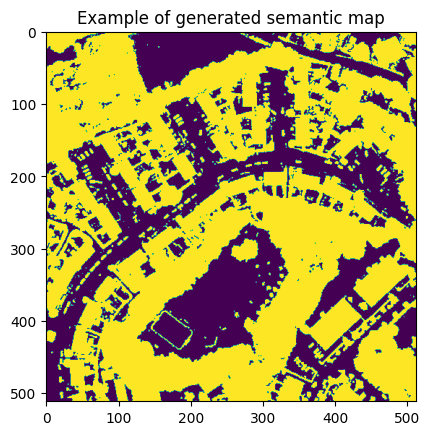

In [17]:
plt.imshow(t_mask[0])
plt.title('Example of generated semantic map')

## ROC

In [18]:
def accuracy(pred, masks):
    tot = 0.0
    n = 0
    N = np.prod(pred.shape)
    for mask in masks.as_numpy_iterator():
        tot += np.sum(pred[n]==mask)
        n += 1
        #print(str(n) + '/' + str(pred.shape[0]), end='\r')
    print(N)
    return tot/N

def recall(pred, masks):
    tot = 0.0
    n = 0
    N = 0
    for mask in masks.as_numpy_iterator():
        op_indices = np.nonzero(mask[0])
        N += op_indices[0].shape[0]
        op = pred[n][op_indices]
        tot += np.sum(op)
        n += 1
        #print(str(n) + '/' + str(pred.shape[0]), end='\r')
    return tot/N   

def fpr(pred, masks): #false positive rate
    tot = 0.0
    n = 0
    N = 0
    for mask in masks.as_numpy_iterator():
        gp_indices = np.where(mask[0] == 0)
        N += gp_indices[0].shape[0]
        gp = pred[n][gp_indices]
        tot += np.sum(gp)
        n += 1
        #print(str(n) + '/' + str(pred.shape[0]), end='\r')
    return tot/N   

In [19]:
print('accuracy : ' + str(accuracy(t_mask, test_dataset512.map(lambda x, y:y))))
print('recall : ' + str(recall(t_mask, test_dataset512.map(lambda x, y:y))))

67108864
accuracy : 0.9444923996925354
recall : 0.9606675523380028


In [ ]:
recall_list256 = []
fpr_list256 = []
start = time.time()
n = 0
for t in np.arange(0,1.05,0.05):
    mask = (preds256>=t).astype('int32')
    recall_list256.append(recall(mask, test_dataset.map(lambda x, y:y)))
    fpr_list256.append(fpr(mask, test_dataset.map(lambda x, y:y)))
    print(n, end='\r')
    n += 1
mask = (preds256>1).astype('int32')
recall_list256.append(recall(mask, test_dataset.map(lambda x, y:y)))
fpr_list256.append(fpr(mask, test_dataset.map(lambda x, y:y)))
print(time.time()-start)
plt.plot(fpr_list256, recall_list256)

recall_list_aspp = []
fpr_list_aspp = []
start = time.time()
n = 0
for t in np.arange(0,1.05,0.05):
    mask = (preds_aspp>=t).astype('int32')
    recall_list_aspp.append(recall(mask, test_dataset512.map(lambda x, y:y)))
    fpr_list_aspp.append(fpr(mask, test_dataset512.map(lambda x, y:y)))
    print(n, end='\r')
    n += 1
mask = (preds_aspp>1).astype('int32')
recall_list_aspp.append(recall(mask, test_dataset512.map(lambda x, y:y)))
fpr_list_aspp.append(fpr(mask, test_dataset512.map(lambda x, y:y)))
print(time.time()-start)
plt.plot(fpr_list_aspp, recall_list_aspp)

In [ ]:
print('fpr:')
print('l: ' + str(l_fpr_list[13]))
print('r: ' + str(r_fpr_list[10]))
print('recall: ')
print('l: ' + str(l_recall_list[13]))
print('r: ' + str(r_recall_list[10]))

In [ ]:
new_l_mask = (l_preds>=0.65).astype('int32')

In [ ]:
print(["%.4f" % i for i in recall_list256])
print(["%.4f" % i for i in fpr_list256])
print(["%.4f" % i for i in recall_list512])
print(["%.4f" % i for i in fpr_list512])

In [ ]:
plt.plot(fpr_list256, recall_list256, zorder=-1, label='256')
plt.plot(fpr_list_aspp, recall_list_aspp, zorder=-1, label='aspp')
#plt.scatter([l_fpr_list[13]],[l_recall_list[13]], s=40, marker='x', color='r', zorder=1, label='threshold=0.65')
plt.scatter([fpr_list256[10]],[recall_list256[10]], s=40, marker='x', color='r', zorder=1, label='threshold=0.5 (normal)')
plt.scatter([fpr_list_aspp[10]],[recall_list_aspp[10]], s=40, marker='x', color='g', zorder=1, label='threshold=0.5 (aspp)')
plt.title('ROC curves of the pix2pix network and the one with the ASPP module')
plt.xlabel('False positive rate')
plt.ylabel('Recall')
plt.xlim([-0.05, 0.6])
plt.legend()
plt.grid()
#plt.savefig('ROC__aspp.png')

## Additional height due to false negatives

In [23]:
def add_height(mask, dataset):
    ad_h = 0
    n = 0
    N = 0
    all_heights = []
    for ndsm in (dataset.map(lambda x, y: x[:,:,0] - y).as_numpy_iterator()):
        if False:#n <30:
            fig, axs = plt.subplots(1,3)
            fig.set_figheight(4)
            fig.set_figwidth(11)
            ax = axs[0]
            ax.title.set_text('nDSM ' + str(n))
            im = ax.imshow(ndsm)
            ax.axis('off')

            ax = axs[1]
            ax.title.set_text('Predicted mask')
            im = ax.imshow(mask[n])
            ax.axis('off')
            
            ax = axs[2]
            ax.title.set_text('Relative height\n of false negatives')
            im = ax.imshow((np.abs(ndsm) * ((-1)*mask[n][:,:,0]+1)))
            fig.set_figheight(3)
            cbar = fig.colorbar(im, ax=ax)
            cbar.ax.set_ylabel('Height (m)')
            ax.axis('off')
            plt.savefig('add_height.png')

        heights = ndsm * ((-1)*mask[n][:,:,0]+1)
        sum_height = np.sum(heights)
        ad_h += sum_height
        all_heights.append(heights)
        N += np.prod(ndsm.shape)
        n += 1
    #print(N)
    return ad_h, all_heights

In [25]:
#ad, heights = add_height(mask256, raw_dataset)
ad, heights512 = add_height(t_mask, raw_dataset512)

#hist = np.histogram(np.reshape(heights, 256*256*1024), bins=100)
hist512 = np.histogram(np.reshape(heights512, 256*256*1024), bins=100)

In [ ]:
print(100*np.max(hist512[0]/np.sum(hist[0])))

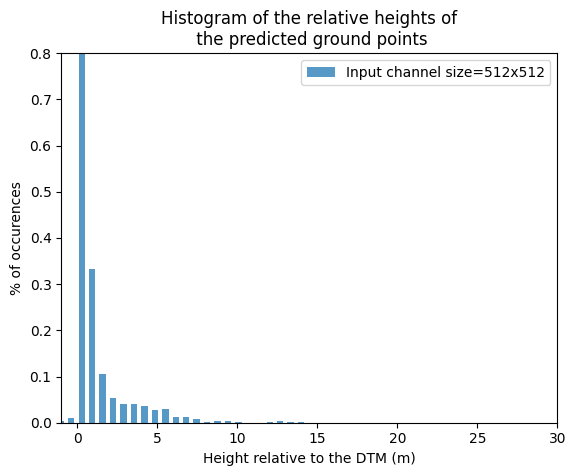

In [26]:
#plt.bar(hist[1][1:], hist[0]*100/np.sum(hist[0]), width=0.4, label='Input channel size=256x256')
plt.bar(hist512[1][1:], hist512[0]*100/np.sum(hist512[0]), alpha=0.75, width=0.4, label='Input channel size=512x512')
plt.xlim([-1,30])
plt.ylim([0, 0.8])
plt.title('Histogram of the relative heights of\n the predicted ground points')
plt.xlabel('Height relative to the DTM (m)')
plt.ylabel('% of occurences')
plt.legend()
#plt.savefig('hist_add_height512.png')

604.696


(0.0, 1000.0)

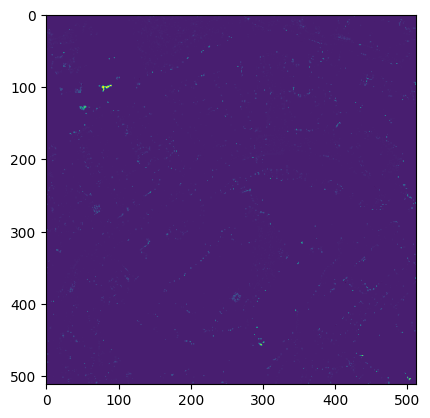

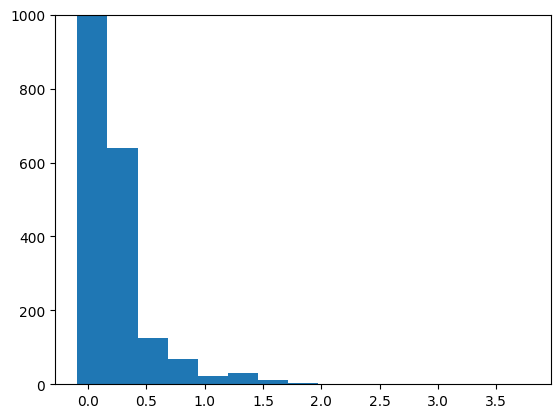

In [28]:
ndsm = [i for i in raw_dataset512.map(lambda x, y: x[:,:,0]-y).take(40)][0]
plt.imshow(np.minimum((t_mask[0]*(-1)+1)[:,:,0]*ndsm, 1.0))
print(np.sum((t_mask[0]*(-1)+1)[:,:,0]*ndsm))
plt.figure()
plt.hist(np.reshape((t_mask[0]*(-1)+1)[:,:,0]*ndsm, 512*512), bins=15)
plt.ylim([0,1000])

In [ ]:
n = 0
tah_list256=[]
for t in np.arange(0,1,0.05):
    mask = (preds256>=t).astype('int32')
    ah = add_height(mask, raw_dataset)
    tah_list256.append(ah)
    print(n, end='\r')
    n += 1
print('ok')
n = 0
tah_list_aspp=[]
for t in np.arange(0,1,0.05):
    mask = (preds_aspp>=t).astype('int32')
    ah = add_height(mask, raw_dataset512)
    tah_list_aspp.append(ah)
    print(n, end='\r')
    n += 1
#plt.plot(l_fpr_list, l_tah_list)

In [ ]:
plt.plot(fpr_list256[:-2], np.array(tah_list256)/(1000*1024), zorder=2, label='256')
plt.plot(fpr_list_aspp[:-2], np.array(tah_list_aspp)/(1000*1024), zorder=2, label='512')
#for i in range(0, 18, 2):
#    plt.scatter([fpr_list256[i]],[np.array(tah_list256[i])/(1000*1024)], s=50, marker='x', color='r', zorder=3, label='threshold=0.5 (256)')
#    plt.scatter([fpr_list512[i]],[np.array(tah_list512[i])/(1000*1024)], s=50, marker='x', color='g', zorder=3, label='threshold=0.5 (512)')

plt.scatter([fpr_list256[10]],[np.array(tah_list256[10])/(1000*1024)], s=50, marker='x', color='r', zorder=3, label='threshold=0.5 (256)')
plt.scatter([fpr_list_aspp[10]],[np.array(tah_list_aspp[10])/(1000*1024)], s=50, marker='x', color='g', zorder=3, label='threshold=0.5 (512)')

plt.xlim([0.02,1.02])
plt.ylim([0,8])
plt.xlabel('False positive rate')
plt.ylabel('Total added height per image (km)')
plt.legend()
plt.title('Comparison of total added height curve for networks\n with inputs channels of 256x256 and 512x512 pixels')
plt.grid(zorder=1)
plt.savefig('ROC_tah_512.png')

In [ ]:
2000/(256*256)

In [ ]:
l_av_ah_list

In [ ]:
n = 0
r_tah_list=[]
r_av_ah_list=[]
for t in np.arange(0,1.05,0.05):
    mask = (r_preds>=t).astype('int32')
    ah, av_ah = add_height(mask, raw_dataset)
    r_tah_list.append(ah)
    r_av_ah_list.append(av_ah)
    print(n, end='\r')
    n += 1
mask = (r_preds>1).astype('int32')
ah, av_ah = add_height(mask, raw_dataset)
r_tah_list.append(ah)
r_av_ah_list.append(av_ah)

### Visual observations

In [ ]:
images = [tf.cast(i[:,:,1:], 'int32') for i in raw_dataset512.map(lambda x, y:x).take(100)]
masks =[i[0] for i in test_dataset512.map(lambda x, y: y).take(100)]
for i in range(100):
    if i == 35: #in [2,35,38,52,60,69,70,82,87]:
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax = axs[0,0]
        ax.title.set_text('Orthophoto')
        im = ax.imshow(images[i])
        ax.axis('off')
        ax = axs[0,1]
        ax.title.set_text('True mask')
        im = ax.imshow(masks[i])
        ax.axis('off')
        ax = axs[1,0]
        ax.title.set_text('True mask - predicted mask')
        im = ax.imshow(masks[i] - mask_aspp[i])
        ax.axis('off')
        ax = axs[1,1]
        ax.title.set_text('Predicted mask')
        im = ax.imshow(mask_aspp[i])
        ax.axis('off')
        plt.savefig('Figures/seg/mask_images/large_zones.png')